# Hiperparametros para la prediccion

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Dataset

In [2]:
parcelas = gpd.read_file('../data/parcelas_sur_prices_.geojson')

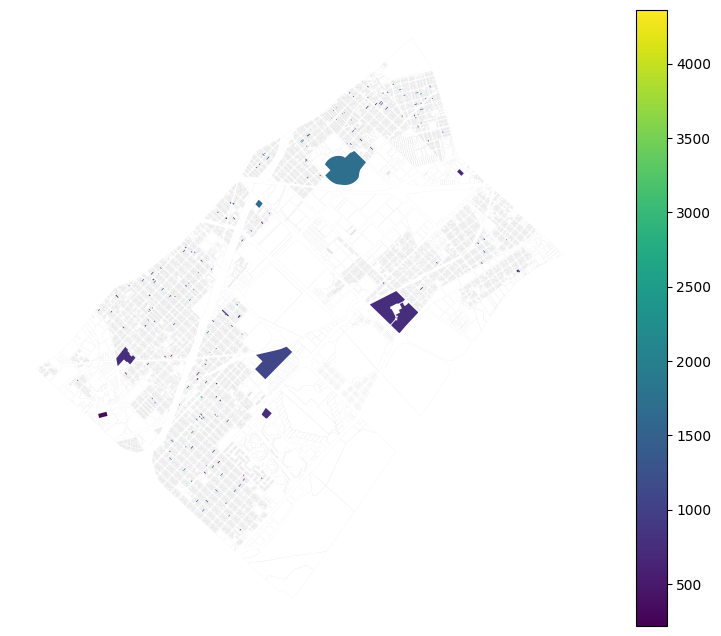

In [3]:
f, ax = plt.subplots(figsize=(12,8))

parcelas.geometry.boundary.plot(ax=ax, color='black', linewidth=0.01)
parcelas[~parcelas['usdm2'].isin([np.nan, np.inf, -np.inf])].plot(column='usdm2', ax=ax, legend=True)
ax.set_axis_off();

In [4]:
from REM.utils import neighbor_fields

In [5]:
# vecinos
gkbs = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'
parcels_nanout = parcelas[~parcelas['usdm2_f'].isna()].copy()
parcelas_ = neighbor_fields(poly_gdf=parcels_nanout, 
                            proj=gkbs, N=1, field_name='usdm2_f')

In [6]:
len(parcelas_)

394

In [7]:
# UNIVERSO TOTAL
parcelas[['usdm2','usdm2_f','price_adj']].isna().value_counts()

usdm2  usdm2_f  price_adj
True   True     True         27676
       False    False          213
False  False    False          181
dtype: int64

In [8]:
parcelas_.head(3)

,geometry,smp,usdm2_f,area,nearest_id_1,nearest_id_2,nearest_smp_1,nearest_price_1,nearest_area_1,nearest_smp_2,nearest_price_2,nearest_area_2
49,POINT (-58.43928 -34.63742),044-149A-006g,1078.792857,236.080455,1,3,044-147B-015,1610.786982,142.045059,044-147B-018a,1149.063107,159.858240
83,POINT (-58.43903 -34.63875),044-147B-015,1610.786982,142.045059,3,112,044-147B-018a,1149.063107,159.858240,044-135-003b,943.737500,133.979543
186,POINT (-58.43769 -34.63898),044-147A-002,942.146544,110.398168,4,3,044-147A-003,978.841716,340.896208,044-147B-018a,1149.063107,159.858240


# 2. Target & Variables explicativas

In [ ]:
#cu_root ='https://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/codigo-urbanistico/codigo-urbanistico.geojson'
#cu = gpd.read_file(cu_root)
#uva19 = dict(zip(cu['smp'],cu['inc_uva_19']))
#df['uva19'] = df.smp.map(uva19)
#df[expvars+['uva19']]

In [9]:
from REM.datasources import api_parcelas

In [10]:
parcelas_extra_ft = api_parcelas(parcelas_['smp'].values)

******************************************
Retrieving parcels from CATASTRO API ...
******************************************
Parcelas consultadas:394
 
... procesando resultados
Parcelas obtenidas: 1
Parcelas obtenidas: 2
Parcelas obtenidas: 3
Parcelas obtenidas: 4
Parcelas obtenidas: 5
Parcelas obtenidas: 6
Parcelas obtenidas: 7
Parcelas obtenidas: 8
Parcelas obtenidas: 9
Parcelas obtenidas: 10
Parcelas obtenidas: 11
Parcelas obtenidas: 12
Parcelas obtenidas: 13
Parcelas obtenidas: 14
Parcelas obtenidas: 15
Parcelas obtenidas: 16
Parcelas obtenidas: 17
Parcelas obtenidas: 18
Parcelas obtenidas: 19
Parcelas obtenidas: 20
Parcelas obtenidas: 21
Parcelas obtenidas: 22
Parcelas obtenidas: 23
Parcelas obtenidas: 24
Parcelas obtenidas: 25
Parcelas obtenidas: 26
Parcelas obtenidas: 27
Parcelas obtenidas: 28
Parcelas obtenidas: 29
Parcelas obtenidas: 30
Parcelas obtenidas: 31
Parcelas obtenidas: 32
Parcelas obtenidas: 33
Parcelas obtenidas: 34
Parcelas obtenidas: 35
Parcelas obtenidas: 36
P

In [11]:
parcelas_xtft_df = pd.concat(parcelas_extra_ft)

In [12]:
api_cols = ['superficie_total', 'superficie_cubierta', 'frente', 'fondo',
            'propiedad_horizontal', 'pisos_bajo_rasante', 'pisos_sobre_rasante',
            'unidades_funcionales', 'locales', 'vuc', 'cantidad_puertas',
            'lon_ctroid', 'lat_ctroid']

In [13]:
api_feat = parcelas_xtft_df[api_cols].copy()

In [14]:
api_feat.head(2)

,superficie_total,superficie_cubierta,frente,fondo,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas,lon_ctroid,lat_ctroid
codigo,,,,,,,,,,,,,
044-149A-006G,230.00,285.00,8.66,26.56,Si,0,2,7,0,0.00,1,-58.439282,-34.637419
044-147B-015,135.00,195.00,7.72,17.49,Si,0,1,3,0,0.00,3,-58.439028,-34.638746


In [15]:
parcelas_base = parcelas_.set_index('smp').copy()

In [16]:
corrections = []
for idx in parcelas_base.index:
    if idx[-1].islower():
        corrections.append(idx[:-1]+idx[-1].upper())
    else:
        corrections.append(idx)

In [17]:
parcelas_base.index = corrections

In [18]:
len(parcelas_base)

394

In [19]:
xvars_union = parcelas_base.join(api_feat)
xvars_union['lat_ctroid'].isna().value_counts() # 5 perdidos

False    389
True       5
Name: lat_ctroid, dtype: int64

In [20]:
parcel_feats = xvars_union.loc[~xvars_union['lat_ctroid'].isna()].copy()

In [21]:
parcel_feats.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 389 entries, 044-149A-006G to 078-158A-000A
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              389 non-null    geometry
 1   usdm2_f               389 non-null    float64 
 2   area                  389 non-null    float64 
 3   nearest_id_1          389 non-null    int64   
 4   nearest_id_2          389 non-null    int64   
 5   nearest_smp_1         389 non-null    object  
 6   nearest_price_1       389 non-null    float64 
 7   nearest_area_1        389 non-null    float64 
 8   nearest_smp_2         389 non-null    object  
 9   nearest_price_2       389 non-null    float64 
 10  nearest_area_2        389 non-null    float64 
 11  superficie_total      377 non-null    object  
 12  superficie_cubierta   377 non-null    object  
 13  frente                377 non-null    object  
 14  fondo                 377 non-nul

In [22]:
parcel_feats['usdm2_f'].isna().value_counts()

False    389
Name: usdm2_f, dtype: int64

In [23]:
parcel_feats_nanout = parcel_feats.dropna().copy()

In [24]:
parcel_feats_nanout.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 377 entries, 044-149A-006G to 078-011-011
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              377 non-null    geometry
 1   usdm2_f               377 non-null    float64 
 2   area                  377 non-null    float64 
 3   nearest_id_1          377 non-null    int64   
 4   nearest_id_2          377 non-null    int64   
 5   nearest_smp_1         377 non-null    object  
 6   nearest_price_1       377 non-null    float64 
 7   nearest_area_1        377 non-null    float64 
 8   nearest_smp_2         377 non-null    object  
 9   nearest_price_2       377 non-null    float64 
 10  nearest_area_2        377 non-null    float64 
 11  superficie_total      377 non-null    object  
 12  superficie_cubierta   377 non-null    object  
 13  frente                377 non-null    object  
 14  fondo                 377 non-null 

In [25]:
parcel_feats_nanout['superficie_total']= parcel_feats_nanout['superficie_total'].astype(float)
parcel_feats_nanout['superficie_cubierta'] = parcel_feats_nanout['superficie_cubierta'].astype(float)
parcel_feats_nanout['frente'] = parcel_feats_nanout['frente'].astype(float)
parcel_feats_nanout['fondo'] = parcel_feats_nanout['fondo'].astype(float)
parcel_feats_nanout['propiedad_horizontal'] = parcel_feats_nanout['propiedad_horizontal'].replace({'Si':1, 'No':0})
parcel_feats_nanout['pisos_bajo_rasante'] = parcel_feats_nanout['pisos_bajo_rasante'].astype(float)
parcel_feats_nanout['pisos_sobre_rasante'] = parcel_feats_nanout['pisos_sobre_rasante'].astype(float)
parcel_feats_nanout['unidades_funcionales'] = parcel_feats_nanout['unidades_funcionales'].astype(float)
parcel_feats_nanout['locales'] = parcel_feats_nanout['locales'].astype(float)
parcel_feats_nanout['vuc'] = parcel_feats_nanout['vuc'].astype(float)
parcel_feats_nanout['cantidad_puertas'] = parcel_feats_nanout['cantidad_puertas'].astype(float)

In [26]:
parcel_feats_nanout.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 377 entries, 044-149A-006G to 078-011-011
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   geometry              377 non-null    geometry
 1   usdm2_f               377 non-null    float64 
 2   area                  377 non-null    float64 
 3   nearest_id_1          377 non-null    int64   
 4   nearest_id_2          377 non-null    int64   
 5   nearest_smp_1         377 non-null    object  
 6   nearest_price_1       377 non-null    float64 
 7   nearest_area_1        377 non-null    float64 
 8   nearest_smp_2         377 non-null    object  
 9   nearest_price_2       377 non-null    float64 
 10  nearest_area_2        377 non-null    float64 
 11  superficie_total      377 non-null    float64 
 12  superficie_cubierta   377 non-null    float64 
 13  frente                377 non-null    float64 
 14  fondo                 377 non-null 

In [27]:
parcel_feats_nanout.columns

Index(['geometry', 'usdm2_f', 'area', 'nearest_id_1', 'nearest_id_2',
       'nearest_smp_1', 'nearest_price_1', 'nearest_area_1', 'nearest_smp_2',
       'nearest_price_2', 'nearest_area_2', 'superficie_total',
       'superficie_cubierta', 'frente', 'fondo', 'propiedad_horizontal',
       'pisos_bajo_rasante', 'pisos_sobre_rasante', 'unidades_funcionales',
       'locales', 'vuc', 'cantidad_puertas', 'lon_ctroid', 'lat_ctroid'],
      dtype='object')

In [28]:
parcel_feats_nanout

,geometry,usdm2_f,area,nearest_id_1,nearest_id_2,nearest_smp_1,nearest_price_1,nearest_area_1,nearest_smp_2,nearest_price_2,...,fondo,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas,lon_ctroid,lat_ctroid
044-149A-006G,POINT (-58.43928 -34.63742),1078.792857,236.080455,1,3,044-147B-015,1610.786982,142.045059,044-147B-018a,1149.063107,...,26.56,1,0.0,2.0,7.0,0.0,0.0,1.0,-58.439282,-34.637419
044-147B-015,POINT (-58.43903 -34.63875),1610.786982,142.045059,3,112,044-147B-018a,1149.063107,159.858240,044-135-003b,943.737500,...,17.49,1,0.0,1.0,3.0,0.0,0.0,3.0,-58.439028,-34.638746
044-147A-002,POINT (-58.43769 -34.63898),942.146544,110.398168,4,3,044-147A-003,978.841716,340.896208,044-147B-018a,1149.063107,...,12.70,0,0.0,1.0,0.0,0.0,0.0,2.0,-58.437685,-34.638985
044-147B-018A,POINT (-58.43892 -34.63897),1149.063107,159.858240,1,117,044-147B-015,1610.786982,142.045059,044-134-022,1009.059172,...,17.44,1,0.0,1.0,2.0,0.0,0.0,1.0,-58.438917,-34.638974
044-147A-003,POINT (-58.43785 -34.63894),978.841716,340.896208,2,3,044-147A-002,942.146544,110.398168,044-147B-018a,1149.063107,...,38.68,1,0.0,1.0,4.0,0.0,0.0,1.0,-58.437848,-34.638944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
078-143-034,POINT (-58.48993 -34.66482),1191.523669,280.608656,384,386,078-154-029,626.297297,554.031365,078-130-036a,894.303846,...,32.79,0,0.0,1.0,0.0,0.0,0.0,2.0,-58.489931,-34.664824
078-031-006,POINT (-58.49540 -34.67553),566.692308,238.046330,389,390,078-030-001,455.112971,163.570541,078-023A-027,520.348432,...,27.48,0,0.0,1.0,0.0,0.0,0.0,1.0,-58.495404,-34.675532
078-030-001,POINT (-58.49489 -34.67555),455.112971,163.570541,388,390,078-031-006,566.692308,238.046330,078-023A-027,520.348432,...,13.05,1,0.0,1.0,2.0,0.0,0.0,1.0,-58.494892,-34.675554
078-023A-027,POINT (-58.49843 -34.67452),520.348432,314.535706,391,388,078-011-011,774.183432,305.603570,078-031-006,566.692308,...,35.19,1,0.0,1.0,2.0,0.0,0.0,1.0,-58.498428,-34.674524


In [29]:
expvars = ['nearest_price_1', 'nearest_area_1','nearest_price_2', 'nearest_area_2',
           'superficie_total', 'superficie_cubierta', 
           'frente','fondo', 'propiedad_horizontal', 'pisos_bajo_rasante',
           'pisos_sobre_rasante', 'unidades_funcionales', 'locales', 'vuc',
           'cantidad_puertas', 'lon_ctroid', 'lat_ctroid']

target_var = 'usdm2_f'

# 3. Modelado de precios

In [30]:
from REM.models import *

In [31]:
# Target + Explanatory variables & + train/test split
X, y = parcel_feats_nanout[expvars], parcel_feats_nanout[target_var]
data_dmatrix = xgb.DMatrix(data=X,label=y, enable_categorical=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## 3.1. Línea de base 

In [32]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 45)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

In [33]:
print_scores(y_test, preds) # pifia en USD360

RMSE: 357.733435
R_Squared Score : 0.476220


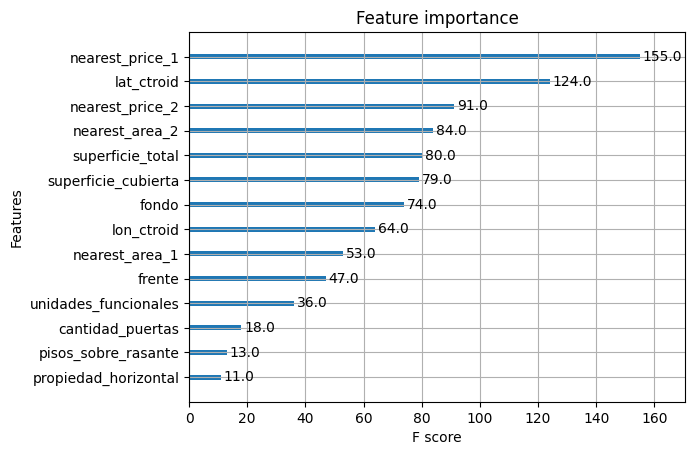

In [34]:
xgb.plot_importance(xg_reg);

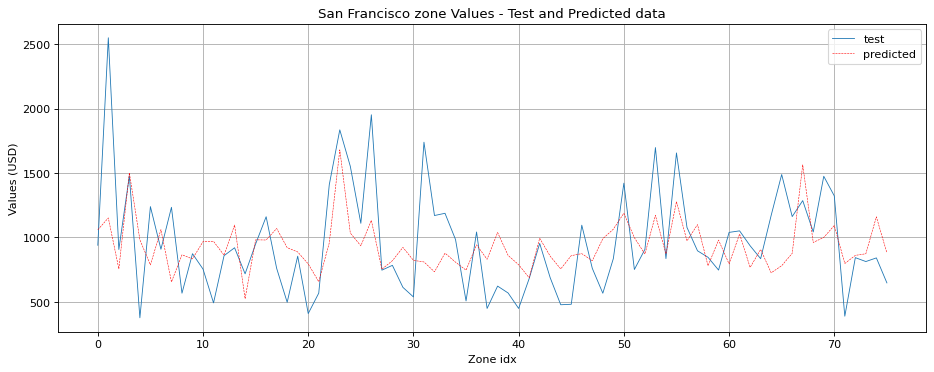

In [35]:
x_ax = range(len(y_test))
plot_predicted_vs_test(x_ax, y_test, preds, predicted_name='Values')

# Tune de hyperparametros

## 1. Cross validation

In [36]:
hyper_parameters = {
                    'colsample_bytree': [0.05, 0.15,0.3,0.4,0.5,0.6,0.7], # percentage of features used per tree
                    'learning_rate': np.linspace(0, 0.6, num=10), #step size to prevent overfitting. Range is [0,1]
                    'max_depth': [2,3,4,10,20], # how deeply each tree is allowed to grow during any boosting round
                    'alpha':[8,16,32,48],
                    'num_boost_round': [15, 25, 30, 200, 500]#number of trees
                            }

In [37]:
min_rmse_scores = {}
nf = 10

for k in hyper_parameters.keys():
    
    if 'colsample_bytree' in k:
        colsample_bytree_scores = test_cv_parameters(k, hyper_parameters, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = colsample_bytree_scores
    
    if 'learning_rate' in k:
        learning_rate_scores = test_cv_parameters(k, hyper_parameters, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = learning_rate_scores
        
    if 'max_depth' in k:
        max_depth_scores = test_cv_parameters(k, hyper_parameters, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = max_depth_scores
        
    if 'alpha' in k:
        alpha_scores = test_cv_parameters(k, hyper_parameters, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = alpha_scores
        
    if 'num_boost_round' in k:
        num_boost_round_scores = test_cv_parameters(k, hyper_parameters, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = num_boost_round_scores

Optimizing colsample_bytree
***************************
0.05
0.15
0.3
0.4
0.5
0.6
0.7
Optimizing learning_rate
************************
0.0
0.06666666666666667
0.13333333333333333
0.2
0.26666666666666666
0.3333333333333333
0.4
0.4666666666666667
0.5333333333333333
0.6
Optimizing max_depth
********************
2
3
4
10
20
Optimizing alpha
****************
8
16
32
48
Optimizing num_boost_round
**************************
15
25
30
200
500


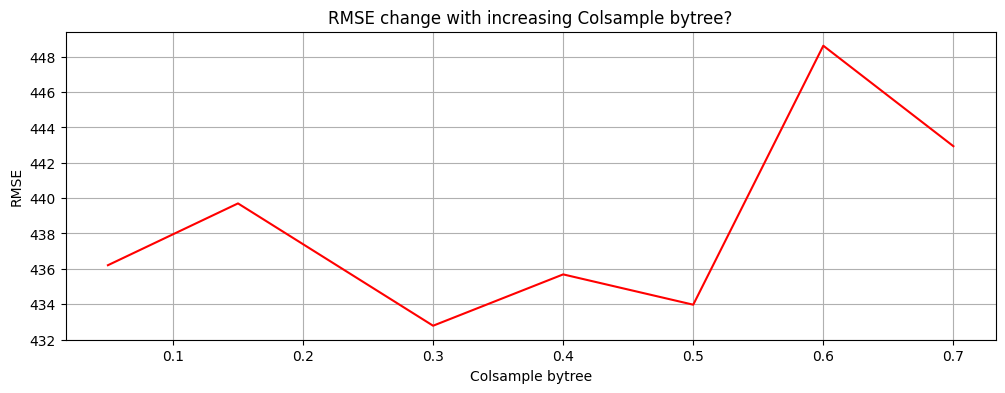

In [38]:
plot_cross_val(alternatives=hyper_parameters['colsample_bytree'],
               results=min_rmse_scores['colsample_bytree_scores'],
               parameter='Colsample bytree', color='red')

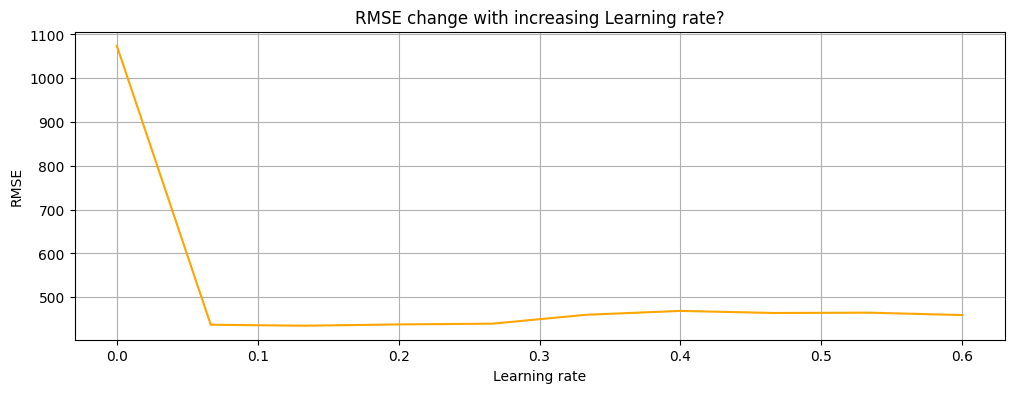

In [39]:
plot_cross_val(alternatives=hyper_parameters['learning_rate'],
               results=min_rmse_scores['learning_rate_scores'],
               parameter='Learning rate', color='orange')

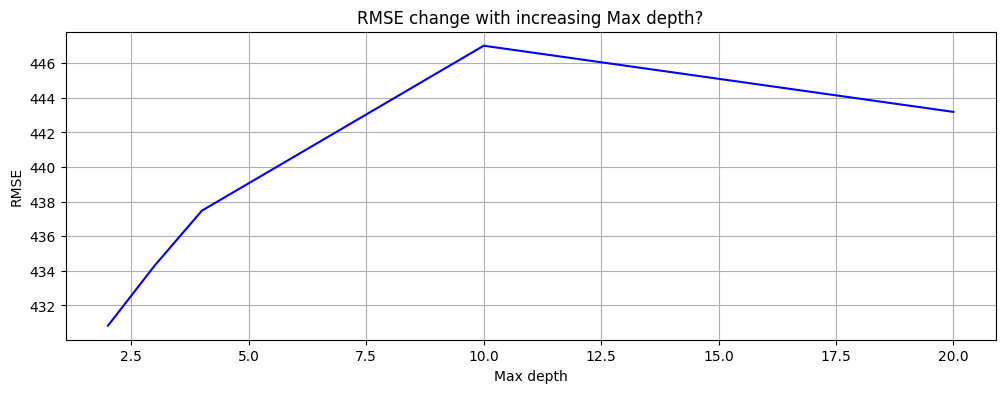

In [40]:
plot_cross_val(alternatives=hyper_parameters['max_depth'],
               results=min_rmse_scores['max_depth_scores'],
               parameter='Max depth', color='blue')

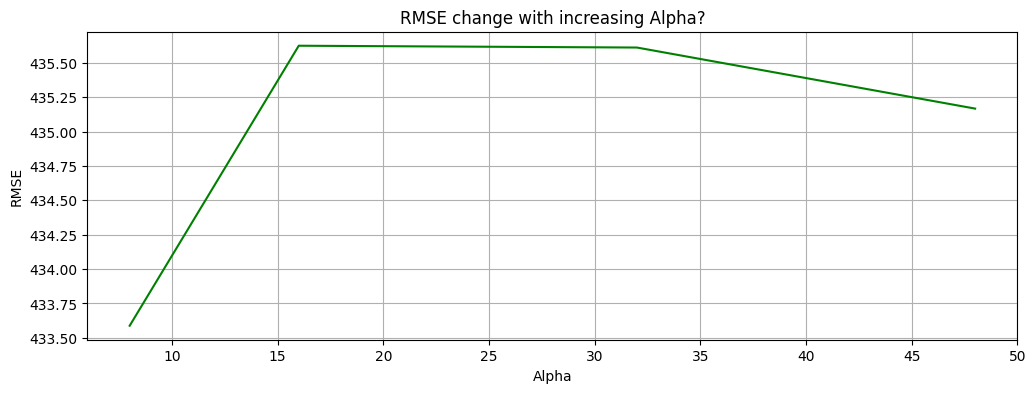

In [41]:
plot_cross_val(alternatives=hyper_parameters['alpha'],
               results=min_rmse_scores['alpha_scores'],
               parameter='Alpha', color='green')

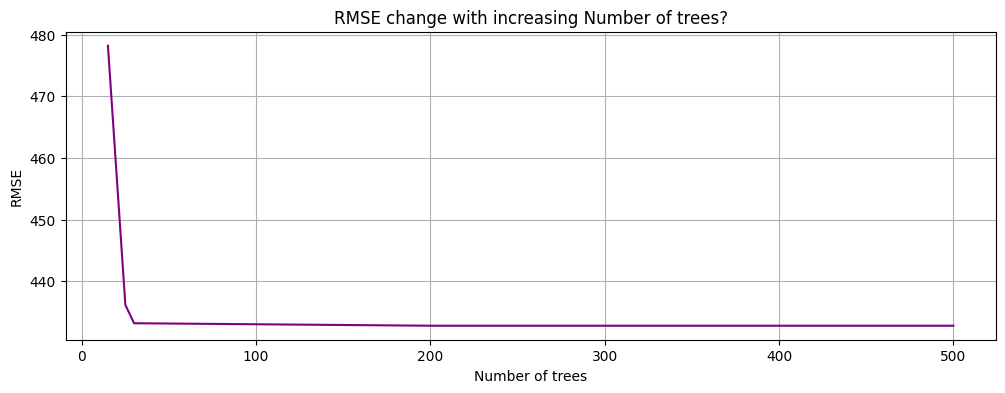

In [42]:
plot_cross_val(alternatives=hyper_parameters['num_boost_round'],
               results=min_rmse_scores['num_boost_round_scores'],
               parameter='Number of trees', color='purple')

In [43]:
best_params = {}

params = ["colsample_bytree", "learning_rate", "max_depth", "alpha", "num_boost_round"]

for p in params:
    o = optimal_hyperparam(dict1=hyper_parameters[p], 
                           dict2=min_rmse_scores[p+'_scores'])
    best_params[p] = o

In [44]:
best_params

{'colsample_bytree': 0.3,
 'learning_rate': 0.13333333333333333,
 'max_depth': 2,
 'alpha': 8,
 'num_boost_round': 200}

In [45]:
xg_reg_cv = xgb.XGBRegressor(objective ='reg:squarederror',
                             colsample_bytree=best_params['colsample_bytree'],
                             learning_rate=best_params['learning_rate'],
                             max_depth=best_params['max_depth'],
                             alpha=best_params['alpha'],
                             n_estimators=best_params['num_boost_round'],
                             subsample=0.25,
                             gamma=1000000
                            )

xg_reg_cv.fit(X_train, y_train)

preds_cv = xg_reg_cv.predict(X_test)

In [46]:
print_scores(y_test, preds_cv) # pifia en USD335

RMSE: 335.792944
R_Squared Score : 0.564555


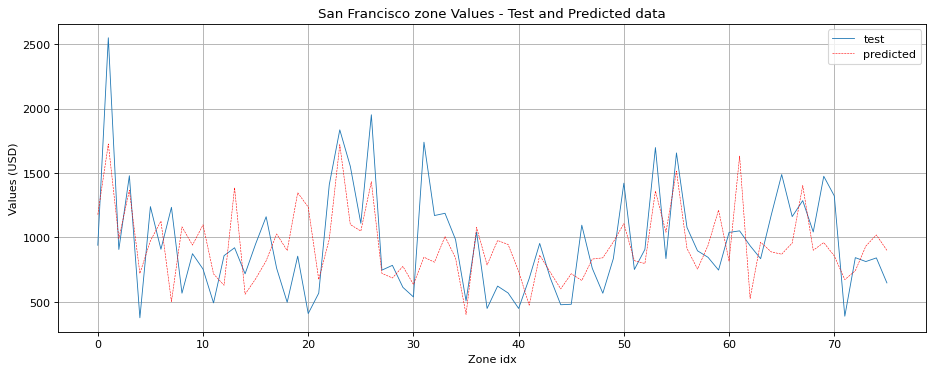

In [47]:
x_ax = range(len(y_test))
plot_predicted_vs_test(x_ax, y_test, preds_cv, predicted_name='Values')

## 2. GridSearch 

In [ ]:
#gs_reg = grid_search_optimization(X_train,y_train)

In [ ]:
#gs_reg.fit(X_train, y_train)

#preds_gs = gs_reg.predict(X_test)
#print_scores(y_test, preds_gs) 

# 4. Prediccion

In [ ]:
to_predict = parcelas[parcelas['usdm2_f'].isna()].copy()

In [ ]:
expvars_df = pd.read_csv('../data/sprecio_expvars.csv')
to_predict.join(expvars)

In [ ]:
predicted_parcels = xg_reg_cv.predict(to_predict[expvars])

In [ ]:
predicted_parcels

In [ ]:
len(to_predict['usdm2_f'])

In [ ]:
len(predicted_parcels)

In [ ]:
to_predict['usdm2_f'] = predicted_parcels

In [ ]:
observed = df[~df['usdm2_f'].isna()].copy()

In [ ]:
predicted = pd.concat([to_predict, observed])

In [ ]:
type(predicted)

In [ ]:
f, ax = plt.subplots(figsize=(12,8))

#parcelas.to_crs(predicted.crs).geometry.boundary.plot(ax=ax, color='black', linewidth=0.01)
predicted.plot(column='usdm2_left', ax=ax, legend=True)
ax.set_axis_off();

In [ ]:
precios = predicted[['smp','usdm2_f']].reset_index().drop(columns='index')
#precios.to_csv('../data/usdm2_parcela_AREA.csv')